In [1]:
import os
import sys
import math
from time import time
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

import xml.etree.ElementTree as ET

from importlib import reload

sys.path.append('/Users/patrickoare/lqcd/utilities')
import pytools as pyt
import plottools as pt
import iotools as io
import formattools as fmt
pt.set_font()
default_style = fmt.styles['notebook']

In [2]:
prop_path = f'/Users/patrickoare/Dropbox (MIT)/research/multigrid/cg_algs/cfgs/ckpoint_lat.4000_m0_m0_wall_meson.xml'
channels = 4
T = 32

In [3]:
reload(io)

<module 'iotools' from '/Users/patrickoare/lqcd/utilities/iotools.py'>

In [4]:
tree = ET.parse(prop_path)
root = tree.getroot()
xml_data = root[0][0]

data = np.zeros((channels, T), dtype = np.complex64)
for channel in range(channels):
    for t in range(T):
        data[channel, t] = io.grid_complex(xml_data[channel][t].text)
assert np.all(np.abs(np.imag(data)) < 1e-8), 'data has complex imaginary part (this is OK, just know where it comes from)'

In [5]:
folded = np.zeros((channels, T // 2), dtype = np.float64)
sgns = [1, 1, -1, -1]
for channel in range(channels):
    folded[channel] = sgns[channel] * np.real(pyt.fold(np.array([data[channel]]), sign = sgns[channel]))

## Propagator plots on single configuration

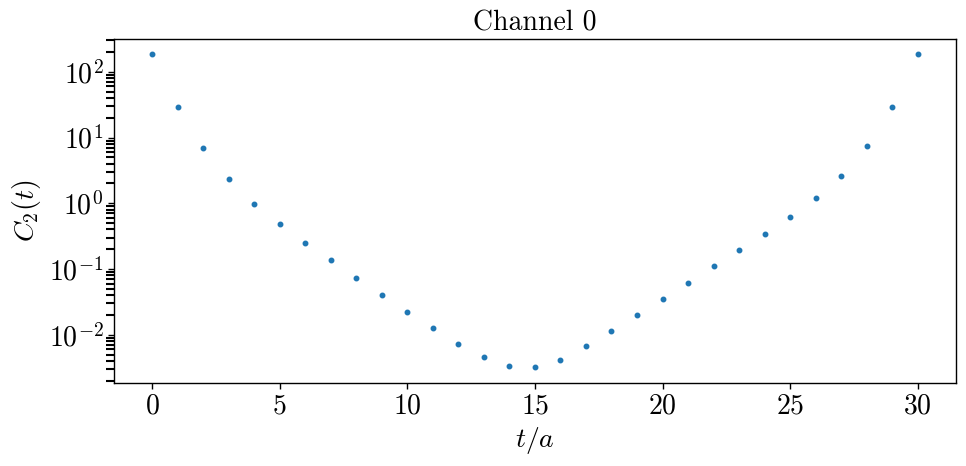

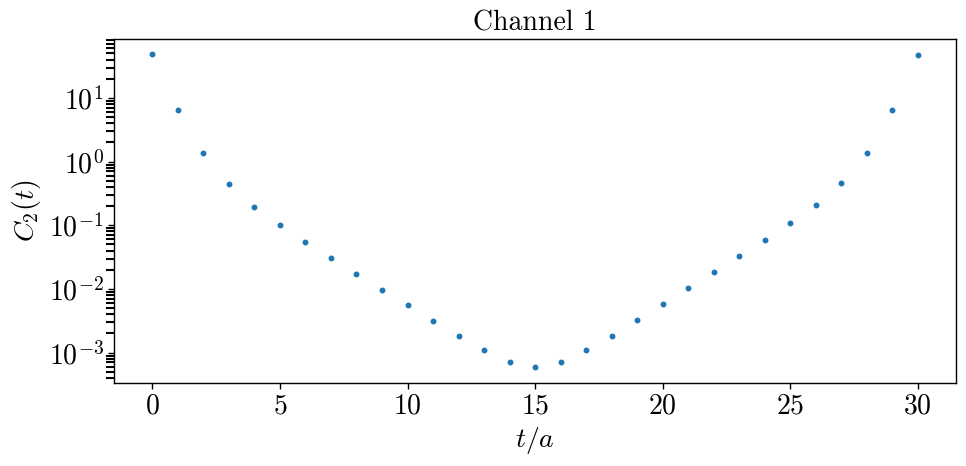

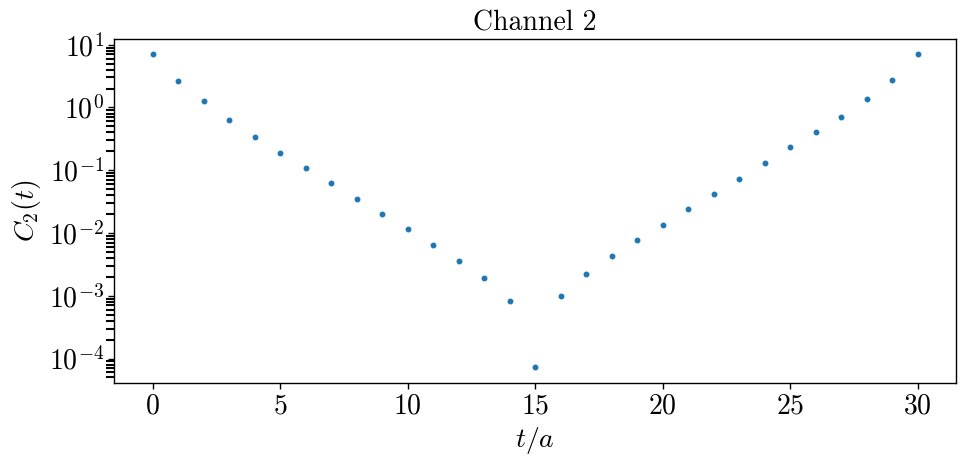

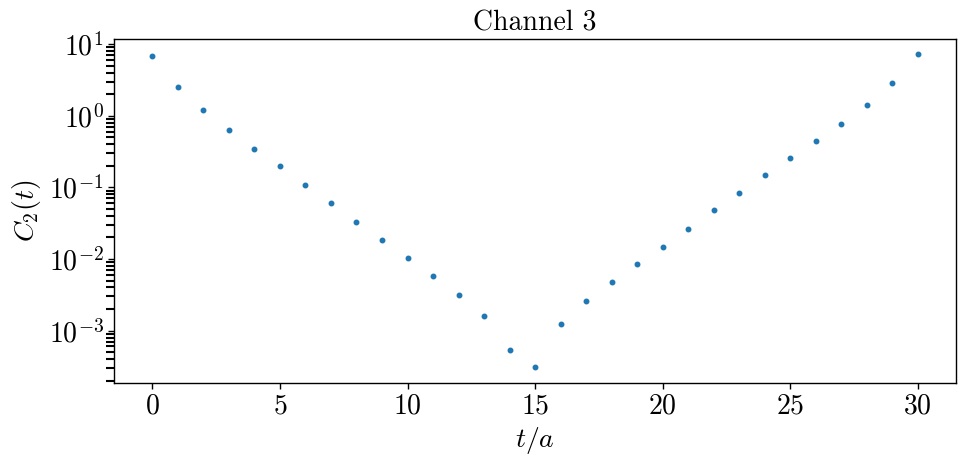

In [6]:
for channel in range(channels):
    # pt.scatter_1d(range(T), np.abs(np.real(data[channel])), logy = True, ax_label = [r'$t/a$', r'$C_2(t)$'], title = f'Channel {channel}')
    pt.scatter_1d(range(T-1), np.abs(np.real(data[channel]))[1:], logy = True, ax_label = [r'$t/a$', r'$C_2(t)$'], title = f'Channel {channel}')

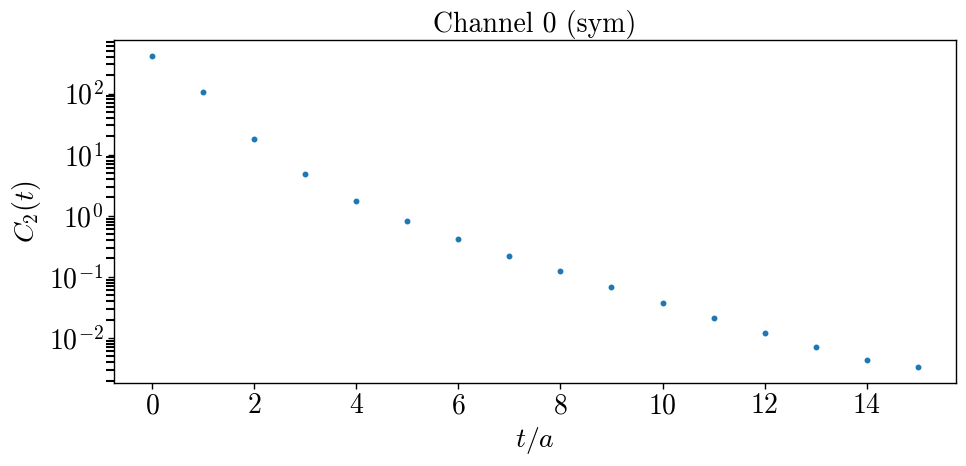

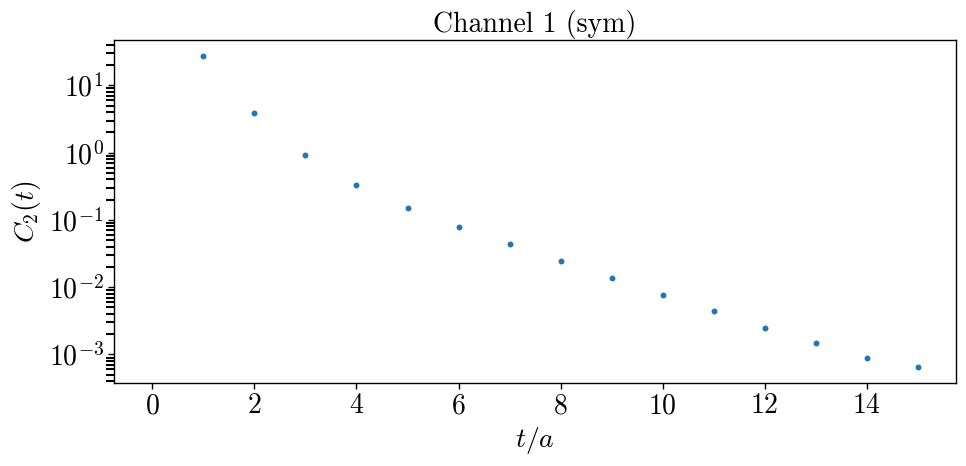

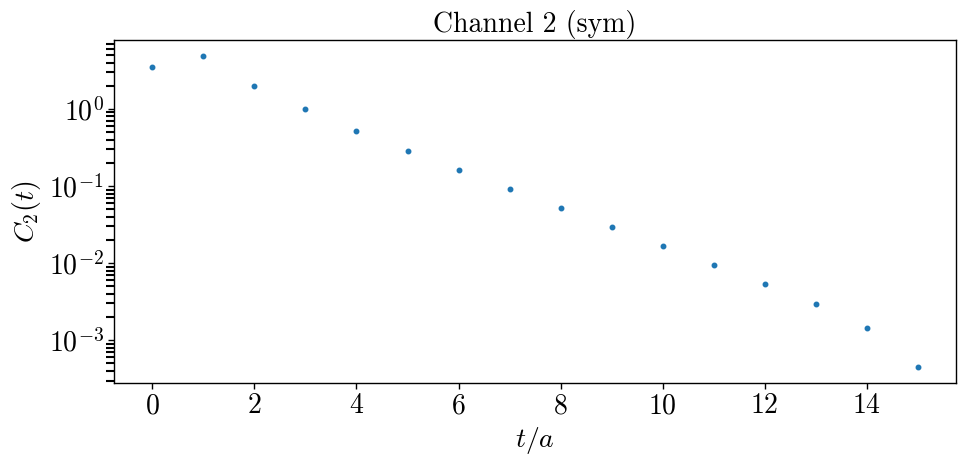

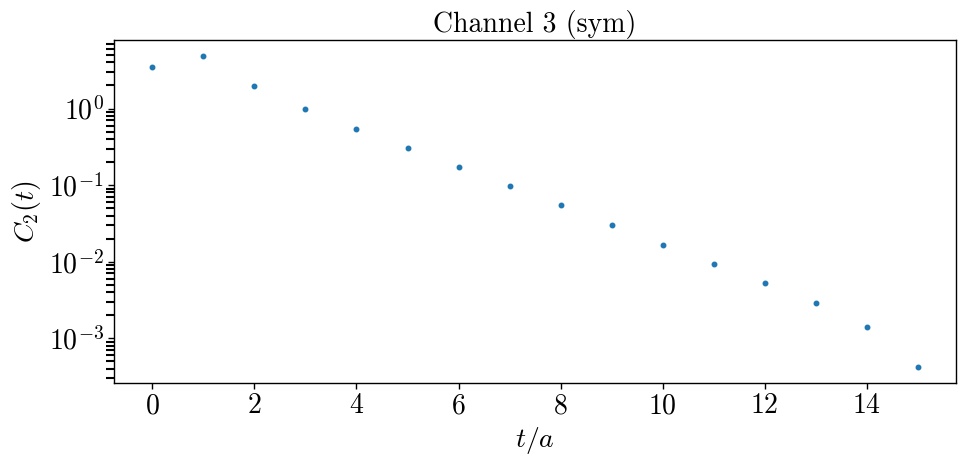

In [7]:
for channel in range(channels):
    pt.scatter_1d(range(T//2), folded[channel], logy = True, ax_label = [r'$t/a$', r'$C_2(t)$'], title = f'Channel {channel} (sym)')

## Plot performance of CGNR vs. CGNE

**Note that these notes follow Saad's conventions for naming the two methods.**
In particular, the existing GRID code follows the **opposite** conventions: in Grid's `algorithms/iterative/NormalEquations.h`, the `NormalEquations` class (CGNE) solves $A^\dagger A x = A^\dagger b$ (Saad's CGNR), and the `NormalResiduals` class (CGNR) solves $AA^\dagger y = b$ and $x = A^\dagger y$ (Saad's CGNE). 

Conjugate Gradient on the Normal Residual (CGNR) and Conjugate Gradient on the Normal Equations (CGNE) are two related ways solve the non-Hermitian system $A x = b$.
- CGNR is the default used in LQCD. The method preconditions the system with $A^\dagger$ on the left, forming the normal equations:
    $$
        A^\dagger A x = A^\dagger b
    $$
  The matrix $A^\dagger A$ is Hermitian, and hence CG can be applied to this system to yield a solution $x^*$. This algorithm can be shown to minimize the **residual** of the problem,
    $$
        x^* = \argmin_{x\in x_0 + K_m(A^TA, A^T r_0)} ||b - A x ||_2^2 = || A (\tilde{x} - x) ||_2^2
    $$
  where $x_0$ is the initial guess, $r_0$ is the initial residual, and the Krylov space $x_0 + K_m(A^TA, A^T r_0)$ is the search space where the solution CG solution lives. 
- CGNE is a similar method that hermitizes the system by right preconditioning with $A^\dagger$ and solving the related system
    $$
        A A^\dagger \xi = b
    $$
  with CG. Given a solution $\xi_*$, the corresponding solution for $x$ can be reconstructed with $x_* = A^\dagger \xi_*$. CGNE minimizes the **error** of the problem:
    $$
        x_* = \argmin_{x\in x_0 + K_m(A^TA, A^T r_0)} || \tilde{x} - x ||_2^2
    $$
  where $\tilde{x}$ is the true solution to the system.

A potential downside to CGNR is when there are low modes present in the system. The condition number of $A^\dagger A$ is the square of the condition number of $A$, meaning if the initial Dirac operator is ill-conditioned, the hermitized Dirac operator is in even worse shape. Likewise, because the two solutions search the same space and minimize different norms, they may have different convergence properties; the system may converge faster under the error norm, rather than the residual norm. 

Target residual = $10^{-8}$. CGNR and CGNE are run to solve the Dirac equation on a single component of a single domain-wall fermion configuration in order to study the convergence properties of the two algorithms. A number of masses are considered; as the mass is lowered, the conditioning number of the problem becomes worse and worse, so if there are problems with CGNR that are exacerbated by low modes, 

In [8]:
masses = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]             # lower masses --> worse conditioned problem
cols = {
    'cgnr' : pt.pal[0], 
    'cgne' : pt.pal[1]
}
# labels = {
#     'cgnr' : r'CGNR ($D^\dagger D\psi = D^\dagger b$; Default)', 
#     'cgne' : r'CGNE ($D D^\dagger \psi^\prime = b^\prime$)',
# }
labels = {
    'cgnr' : r'CGNR', 
    'cgne' : r'CGNE',
}
iterations = {
    'cgnr' : [346, 346, 345, 340, 320, 289, 252, 110],
    'cgne' : [337, 337, 337, 330, 311, 279, 242, 104],
}
computed_resid = {
    'cgnr' : [8.46782701e-09, 9.08075166e-09, 9.05425961e-09, 9.09348613e-09, 8.59198033e-09, 9.19004793e-09, 8.71681141e-09, 9.83170698e-09],
    'cgne' : [9.45186501e-09, 9.76030624e-09, 8.90438886e-09, 8.7800864e-09, 9.13296331e-09, 9.31465311e-09, 8.67420852e-09, 8.63809904e-09],
}
true_resid = {
    'cgnr' : [9.45779664e-09, 1.00055152e-08, 9.97486776e-09, 9.29157156e-09, 8.59236835e-09, 9.19004623e-09, 8.71681141e-09, 9.83170698e-09],
    'cgne' : [9.4518649e-09, 9.76030612e-09, 8.90438885e-09, 8.78008636e-09, 9.1329633e-09, 9.31465311e-09, 8.67420852e-09, 8.63809904e-09],
}
solve_time = {
    'cgnr' : [170.106830, 169.712529, 170.431660, 166.669729, 157.025189, 141.623894, 124.279986, 54.781311], 
    'cgne' : [165.481275, 165.091202, 166.111662, 162.189350, 152.550220, 137.403000, 120.013573, 51.067393], 
}

m_min = 2
m_max = -1
masses = masses[m_min : m_max]
for key in ['cgnr', 'cgne']:
    iterations[key]     = iterations[key][m_min : m_max]
    computed_resid[key] = computed_resid[key][m_min : m_max]
    true_resid[key]     = true_resid[key][m_min : m_max]
    solve_time[key]     = solve_time[key][m_min : m_max]

In [9]:
reload(pt)

<module 'plottools' from '/Users/patrickoare/lqcd/utilities/plottools.py'>

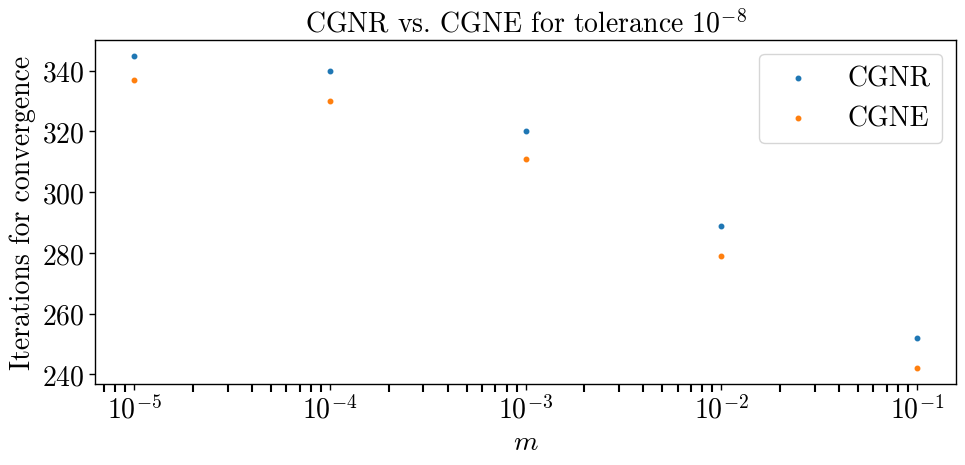

In [10]:
fig, axes = pt.add_subplots()
ax = axes[0]
for lbl in labels.keys():
    pt.scatter_1d(masses, iterations[lbl], ax = ax, logx = True, col = cols[lbl], ax_label = [r'$m$', r'Iterations for convergence'], \
                  fn_label = labels[lbl], title = r'CGNR vs. CGNE for tolerance $10^{-8}$')
plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [11]:
# fig, axes = pt.add_subplots()
# ax = axes[0]
# for lbl in labels.keys():
#     pt.scatter_1d(masses, solve_time[lbl], ax = ax, logx = True, col = cols[lbl], ax_label = [r'$m$', r'Solver Time (s)'], \
#                   fn_label = labels[lbl], title = r'CGNR vs. CGNE for tolerance $10^{-8}$')
# plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

## Plot iterations for CGNR vs CGNE

In [12]:
mstr_lst = [
    '0p1',
    '0p01',
    '0p001',
    '0p0001',
    '0p00001',
]
m_lst = [fmt.str_to_float(mstr) for mstr in mstr_lst]

summed_resid_dir = '/Users/patrickoare/Dropbox (MIT)/research/multigrid/grid_out/summed_residuals'

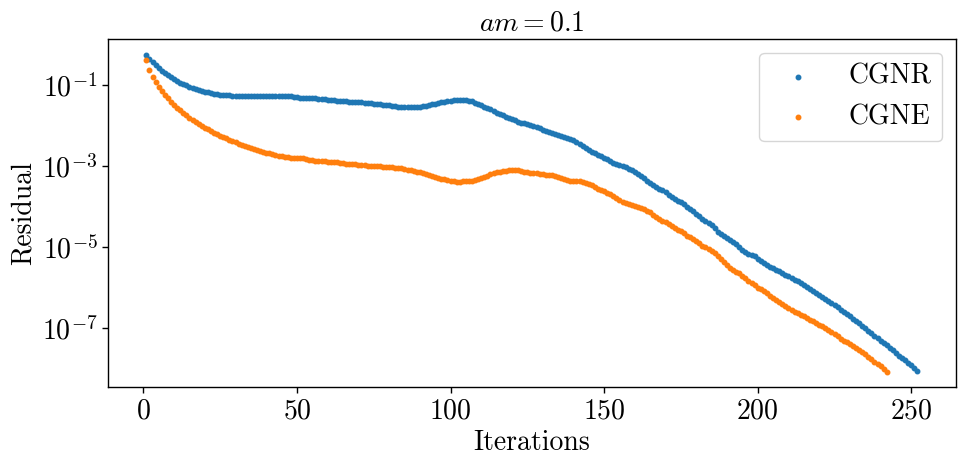

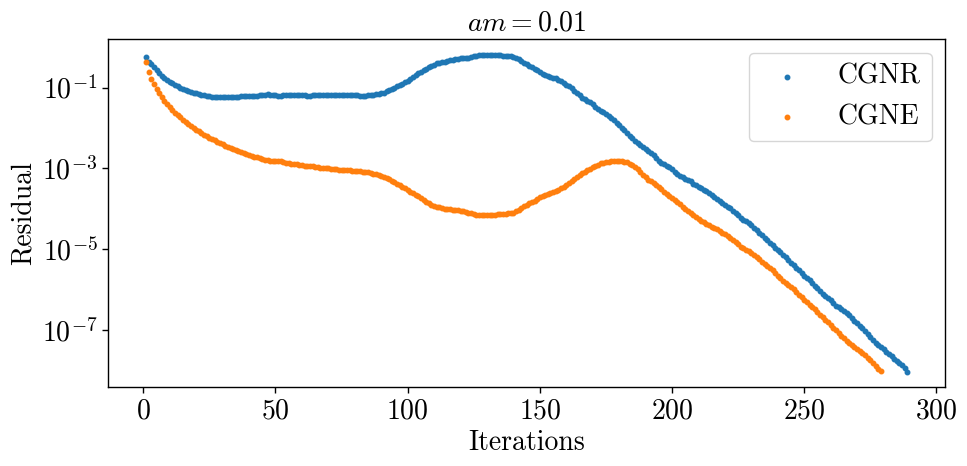

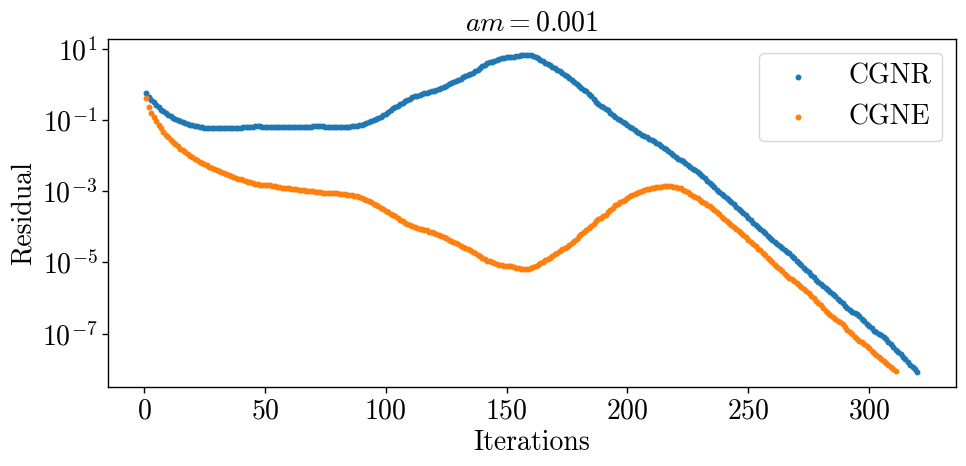

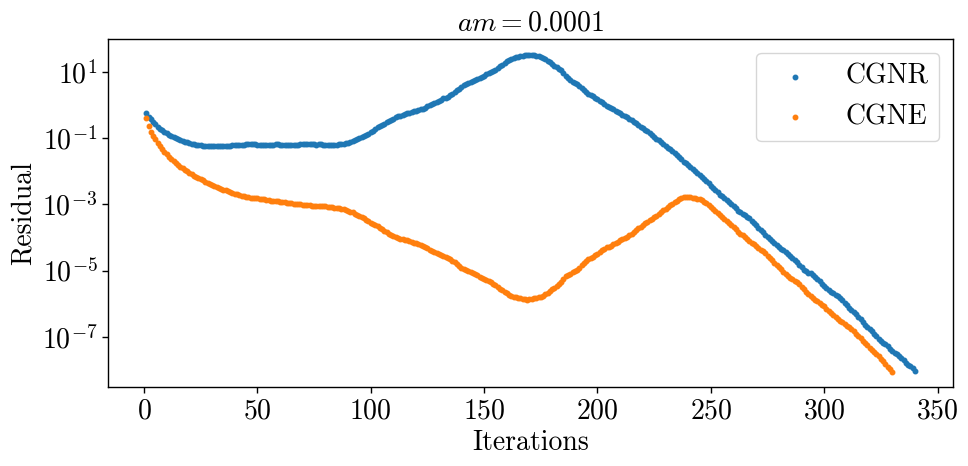

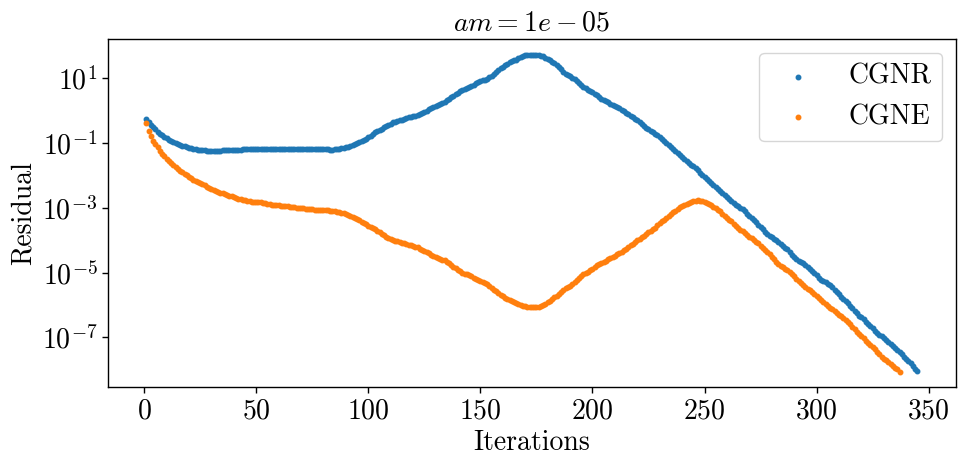

In [13]:
summed_resids = {}
for mstr in mstr_lst:
    resid_file = f'{summed_resid_dir}/m{mstr}.h5'
    f = h5py.File(resid_file, 'r')
    
    cur_resids = {}
    for k in labels.keys():
        cur_resids[k] = f[k][()]
    summed_resids[mstr] = cur_resids

    fig, axes = pt.add_subplots()
    ax = axes[0]
    for lbl in labels.keys():
        pt.scatter_1d(np.arange(1, 1 + len(cur_resids[lbl])), cur_resids[lbl], ax = ax, col = cols[lbl], ax_label = [r'Iterations', r'Residual'], \
                    fn_label = labels[lbl], title = f'$am = {fmt.str_to_float(mstr)}$', logy = True)
    plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

## Study residuals on each time-slice
For iteration $k$, we now consider the residual on each time-slice of the lattice,
$$
    r_k^2(t) = \sum_{\bm x} |D \psi_k (\bm x, t) - b(\bm x, t)|^2
$$
where $\psi_k(\bm x, t)$ is the iterate at iteration $k$ and $b(\bm x, t)$ is the source field. Since CGNR is affected by the low modes of the Dirac operator, the expectation is that the long-distance physics will take longer to converge. The residual per iteration is,
$$
    \mathrm{cp}_k^2 = \sum_t r_k^2(t)
$$
which is computed in `ConjugateGradient.h`, with stopping condition,
$$
    \mathrm{cp}_k^2 \leq \epsilon^2 ||b||_2^2 \iff \frac{\mathrm{cp}_k^2}{||b||_2^2} \leq \epsilon^2.
$$
Currently the tolerance $\epsilon$ is set to $10^{-8}$ in the code. The normalized residual that is output in the code is
$$
    \widetilde{\mathrm{cp}}_k = \sqrt{\frac{\sum_t r_k^2(t)}{||b||_2^2}} = \frac{\mathrm{cp}_k}{||b||_2}
$$
which is what we should be comparing against to ensure that the code is working properly. All residuals shown in this section will be normalized by the source,
$$
    \tilde{r}_k^2(t) = \frac{r_k^2(t)}{||b||_2^2} \hspace{2cm} \widetilde{\mathrm{cp}}_k^2 = \sum_t \tilde{r}_k^2(t)
$$
such that the total residual output by the original CG code is $\tilde{r}_k^2 = \sum_t \tilde{r}_k^2(t)$ and the stopping condition is,
$$
    \sum_t \tilde{r}_k^2(t)\leq \epsilon^2
$$

A useful metric to study convergence is the number of iterations it takes for each time-slice $t$ to converge, given some tolerance $\epsilon_T$. Note that although we ran the algorithm until we hit a solver tolerance of $10^{-8}$, here $\epsilon_T$ corresponds to a tolerance for convergence for the time-slice residual $\widetilde{r}_k(t)$, while the $10^{-8}$ tolerance is for the summed residual $\sqrt{\sum_t \widetilde{r}_k^2(t)}$. 

We compute the number of iterations for convergence with the time-slice tolerance $\epsilon_T\in \{10^{-4}, 10^{-5}, 10^{-6}, 10^{-7}, 10^{-8}\}$, for each time-slice $t$. The hypothesis is that at larger $t$, we should see a larger difference in the number of iterations to converge between CGNR and CGNE, because CGNR feels the effects of the low modes more than CGNE, which manifests in the long-distance physics. 

In [14]:
# load in residuals. resids dict is indexed by [mass]['cgnr' or 'cgne'][iteration, with iteration 0 = source]

wall_src = True
if wall_src:
    resid_dir = '/Users/patrickoare/Dropbox (MIT)/research/multigrid/grid_out/residuals'
else:
    resid_dir = '/Users/patrickoare/Dropbox (MIT)/research/multigrid/grid_out/pt_src/residuals'

resids = {}
for mstr in mstr_lst:
    cur_resids = {}
    f = h5py.File(f'{resid_dir}/m{mstr}.h5', 'r')
    for k in labels.keys():
        cur_resids[k] = f[k][()]
    f.close()
    resids[mstr] = cur_resids

In [15]:
np.sum(resids['0p01']['cgnr'][0]**2)

17544038.25

In [16]:
# resids['0p01']['cgnr'][0]

In [17]:
# np.linalg.norm(resids['0p01']['cgnr'][0])**2

In [18]:
# Note that this reads out the code output for CGNR / CGNE, which is the physics convention (i.e., CGNE is left preconditioning with A^\dag and CGNR is right), and 
# opposite to the math convention
errors = {}
errors['0p01'] = {
    'cgnr' : resids['0p01']['cgnr'][290:],
    'cgne' : resids['0p01']['cgne'][280:],
}
# note that the first component of `iterates` is zero, so the first component of the error vector should be ||x_*||^2
resids['0p01']['cgnr'] = resids['0p01']['cgnr'][:290]
resids['0p01']['cgne'] = resids['0p01']['cgne'][:280]

Some definitions. Each variable in the code is a dictionary with first index the mass string of the Dirac operator it was run with (i.e., `0p01` corresponds to $m = 0.01$) and second string the CG method (`'cgnr'` or `'cgne'`). 
1. `resids` $= r_k^2(t)$, a $(n_\mathrm{itr} + 1)\times T$ matrix. The first component is the source squared $\sum_{\bm x} |b(\bm x, t)|^2$. 
2. `ssq` $= ||b||_2^2$, a scalar.
3. `rsq_normalized` $= \tilde{r}_k^2(t)$, a $n_\mathrm{itr}\times T$ matrix. 
4. `cp` $= \widetilde{\mathrm{cp}}_k$, a $n_\mathrm{itr}$ length vector.

In [19]:
def apply_to_dict(map, dict):
    """
    Applies the input map to every element of resids. 
    """
    return {
        mstr : { 
            k : map(dict[mstr][k]) for k in dict[mstr] 
        } 
        for mstr in dict
    }
# WE NEED TO STORE ||A^\dagger b|| for normalizing the error, this needs to be output by the code
ssq = apply_to_dict(lambda rsq : np.sum(rsq[0]), resids)          # ssq = sum( b^2 ) = sum( rsq[0] )
rsq_normalized = {
    mstr : { k : resids[mstr][k][1:] / ssq[mstr][k] for k in resids[mstr] } for mstr in resids          # rsq_norm(t) = r_k^2(t) / ssq_k
}
cp = apply_to_dict(lambda rsq : np.sqrt(np.sum(rsq, axis = 1)), rsq_normalized)                         # cp_k = sqrt( \sum_t r_k^2(t) / ssq_k )

In [20]:
ssq_b = ssq['0p01']['cgnr']
ssq_Adagb = ssq['0p01']['cgne']

In [21]:
# should be ||A x_*'||. Note that || x_* - A x_*' || is consistent with 0
errors['0p01']['cgnr'][0]

array([179.04  ,  70.8099,  49.6421,  46.2277,  45.3471,  44.968 ,
        44.7248,  44.5341,  44.373 ,  44.2343,  44.1155,  44.0155,
        43.9339,  43.8706,  43.8254,  43.7983,  43.7893,  43.7983,
        43.8254,  43.8706,  43.9339,  44.0155,  44.1155,  44.2344,
        44.3731,  44.5342,  44.7248,  44.9668,  45.3374,  46.169 ,
        49.3187,  69.0806])

In [22]:
errors['0p01']['cgne'][0]

array([179.04  ,  70.8099,  49.6421,  46.2277,  45.3471,  44.968 ,
        44.7248,  44.5341,  44.373 ,  44.2343,  44.1155,  44.0155,
        43.9339,  43.8706,  43.8254,  43.7983,  43.7893,  43.7983,
        43.8254,  43.8706,  43.9339,  44.0155,  44.1155,  44.2344,
        44.3731,  44.5342,  44.7248,  44.9668,  45.3374,  46.169 ,
        49.3187,  69.0806])

In [23]:
# # check that cgnr normalized residuals are the same as previously output from ConjugateGradient.h
# if wall_src:
#     for mstr in mstr_lst:
#         for cg_type in resids[mstr]:
#             assert np.allclose(cp[mstr][cg_type], summed_resids[mstr][cg_type]), f'Normalized {cg_type} residuals for m = {mstr} do not match.'

In [24]:
# tolerances to study at.
tol_rng = range(4, 9)
tolerances = [10**(-n) for n in tol_rng]
tol_lbls = [f'1e-{n}' for n in tol_rng]
tol_latex_lbls = [r'10^{-' + str(n) + r'}' for n in tol_rng]

In [41]:
rsq_normalized['0p01']['cgne']

array([[1.09864960e-01, 3.44191987e-02, 1.62075387e-03, ...,
        0.00000000e+00, 1.62075387e-03, 3.44511099e-02],
       [2.50518993e-02, 1.38623447e-02, 2.02933945e-03, ...,
        5.48010298e-05, 2.03167169e-03, 1.38374512e-02],
       [8.87117441e-03, 6.50216919e-03, 1.84384948e-03, ...,
        1.75671514e-04, 1.84481310e-03, 6.45510541e-03],
       ...,
       [7.99714266e-18, 5.62335425e-18, 4.64419708e-18, ...,
        4.72613974e-18, 4.62171261e-18, 5.61371805e-18],
       [5.92888480e-18, 4.44616608e-18, 3.58327183e-18, ...,
        3.52447701e-18, 3.56927140e-18, 4.43338764e-18],
       [4.79809706e-18, 3.57286752e-18, 3.10721535e-18, ...,
        2.67863814e-18, 3.09690182e-18, 3.56190459e-18]])

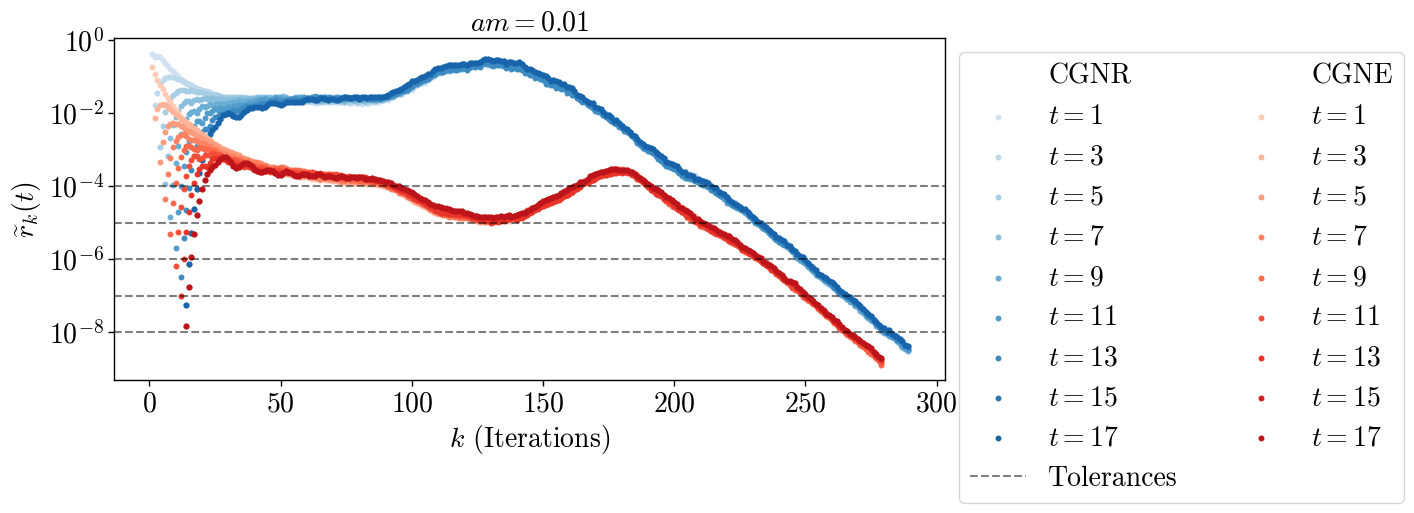

In [40]:
# T = resids[mstr_lst[0]]['cgnr'].shape[1]          # max time
# T = 16
T = 18
# spacing = 4
spacing = 2
# Tplot = np.arange(0, T, spacing)
Tplot = np.arange(1, T, spacing)
nplot = len(Tplot)
cols = {
    'cgnr' : colormaps['Blues'](np.linspace(0.2, 0.8, nplot)),
    'cgne' : colormaps['Reds'](np.linspace(0.2, 0.8, nplot)),
}

for mstr in mstr_lst:
    if mstr != '0p01':
        continue
    fig, axes = pt.add_subplots()
    ax = axes[0]
    add_line_leg = True
    for tol in tolerances:
        if add_line_leg:
            pt.add_line(ax, tol, orientation = 'h', linestyle = '--', c = 'k', alpha = 0.5, label = 'Tolerances')
            add_line_leg = False
        else:
            pt.add_line(ax, tol, orientation = 'h', linestyle = '--', c = 'k', alpha = 0.5)
    for cg_type in resids[mstr]:
        plot_resids = np.sqrt(rsq_normalized[mstr][cg_type])
        if cg_type == 'cgnr':
            plot_resids *= np.sqrt(ssq_b / ssq_Adagb)
        nresids = plot_resids.shape[0]
        for tidx, t in enumerate(Tplot):
            pt.scatter_1d(np.arange(1, 1 + nresids), plot_resids[:, t], ax = ax, col = cols[cg_type][tidx], ax_label = [r'$k$ (Iterations)', r'$\widetilde{r}_k(t)$'], \
                    fn_label = '$t = ' + str(t) + '$', title = f'$am = {fmt.str_to_float(mstr)}$', logy = True)
    h, l = ax.get_legend_handles_labels()
    h_line, l_line = h[0], l[0]
    h, l = h[1:], l[1:]
    handles = [plt.plot([],marker="", ls="")[0]] + h[:len(h) // 2] + [h_line] + [plt.plot([],marker="", ls="")[0]] + h[len(h)//2:]
    big_labels = ['CGNR'] + l[:len(l) // 2] + [l_line] + ['CGNE'] + l[len(l)//2:]
    plt.legend(handles, big_labels, ncol = 2, fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

The error $e_k(t)$ is defined with respect to the converged solution $\psi_*(\bm x, t) \equiv \psi_N(\bm x, t)$, where $N$ is the number of iterations until convergence,
$$
    e_k^2(t) = \sum_{\bm x} | \psi_k(\bm x, t) - \psi_*(\bm x, t) |^2
$$

In [26]:
# np.sqrt(errors['0p01']['cgne'])

Raw output without tinkering would yield the CGNR error output,
$$
    e_k'(t) = ||x_k'(t) - x_*'(t)||.
$$
I've adjusted the code so that CGNR outputs the normalized error,
$$
    e_k(t) = || D^\dagger (x_k'(t) - x_*'(t) ) || = ||x_k(t) - x_*(t)||.
$$
which is the error that the CGNE code produces. However, the error is typically normalized by $||b||$, the source, i.e. the stopping condition is when $|| D x_k - b || / ||b|| < \epsilon$ for some tolerance $\epsilon$. So, most of my code uses the normalized error. The problem is that CGNR uses $b$ as the source to normalize the error with, but CGNE uses $A^\dagger b$ as the source. 

In [27]:
# errors[m]['cgnr'] = || x - x_* ||
# errors[m]['cgne'] = 
errors

{'0p01': {'cgnr': array([[1.79040e+02, 7.08099e+01, 4.96421e+01, ..., 4.61690e+01,
          4.93187e+01, 6.90806e+01],
         [9.54995e+01, 6.61937e+01, 4.96421e+01, ..., 4.61690e+01,
          4.93187e+01, 6.46552e+01],
         [7.40499e+01, 6.16037e+01, 4.95456e+01, ..., 4.61690e+01,
          4.92263e+01, 6.03223e+01],
         ...,
         [1.20687e-15, 8.55061e-16, 7.08757e-16, ..., 6.54329e-16,
          7.01592e-16, 8.48444e-16],
         [5.70988e-16, 4.34121e-16, 3.34253e-16, ..., 3.22763e-16,
          3.34116e-16, 4.33624e-16],
         [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
          0.00000e+00, 0.00000e+00]]),
  'cgne': array([[1.79040e+02, 7.08099e+01, 4.96421e+01, ..., 4.61690e+01,
          4.93187e+01, 6.90806e+01],
         [1.01266e+02, 6.61148e+01, 4.96421e+01, ..., 4.61690e+01,
          4.93187e+01, 6.45295e+01],
         [7.99333e+01, 6.22951e+01, 4.95212e+01, ..., 4.61690e+01,
          4.92001e+01, 6.08777e+01],
         ...,
         [

In [28]:
# should be equal to \vec{0} if we get the normalization correct!
errors['0p01']['cgnr'][0] - errors['0p01']['cgne'][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

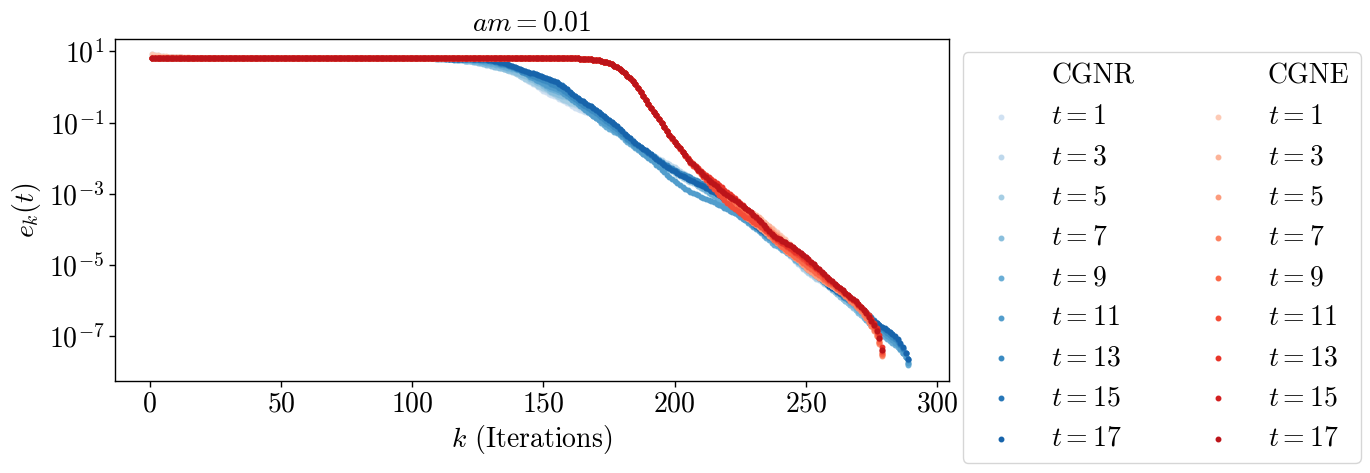

In [36]:
for mstr in ['0p01']:
    fig, axes = pt.add_subplots()
    ax = axes[0]
    for cg_type in resids[mstr]:
        plot_errors = np.sqrt(errors[mstr][cg_type])
        # if cg_type == 'cgnr':
        #     plot_errors *= np.sqrt(ssq_b / ssq_Adagb)
        nerrors = plot_errors.shape[0]
        for tidx, t in enumerate(Tplot):
            pt.scatter_1d(np.arange(1, 1 + nerrors), plot_errors[:, t], ax = ax, col = cols[cg_type][tidx], ax_label = [r'$k$ (Iterations)', r'$e_k(t)$'], \
                    fn_label = '$t = ' + str(t) + '$', title = f'$am = {fmt.str_to_float(mstr)}$', logy = True)
    h, l = ax.get_legend_handles_labels()
    handles = [plt.plot([],marker="", ls="")[0]] + h[:len(h) // 2] + [plt.plot([],marker="", ls="")[0]] + h[len(h)//2:]
    big_labels = ['CGNR'] + l[:len(l) // 2] + ['CGNE'] + l[len(l)//2:]
    plt.legend(handles, big_labels, ncol = 2, fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

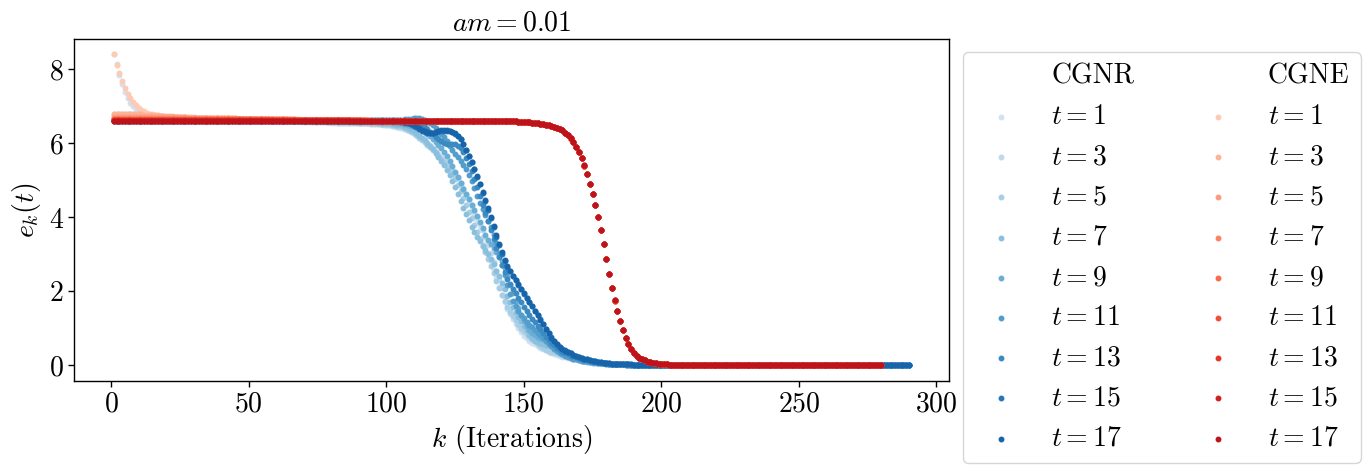

In [35]:
for mstr in ['0p01']:
    fig, axes = pt.add_subplots()
    ax = axes[0]
    for cg_type in resids[mstr]:
        plot_errors = np.sqrt(errors[mstr][cg_type])
        # if cg_type == 'cgnr':
        #     plot_errors *= np.sqrt(ssq_b / ssq_Adagb)
        nerrors = plot_errors.shape[0]
        for tidx, t in enumerate(Tplot):
            pt.scatter_1d(np.arange(1, 1 + nerrors), plot_errors[:, t], ax = ax, col = cols[cg_type][tidx], ax_label = [r'$k$ (Iterations)', r'$e_k(t)$'], \
                    fn_label = '$t = ' + str(t) + '$', title = f'$am = {fmt.str_to_float(mstr)}$')
    h, l = ax.get_legend_handles_labels()
    handles = [plt.plot([],marker="", ls="")[0]] + h[:len(h) // 2] + [plt.plot([],marker="", ls="")[0]] + h[len(h)//2:]
    big_labels = ['CGNR'] + l[:len(l) // 2] + ['CGNE'] + l[len(l)//2:]
    plt.legend(handles, big_labels, ncol = 2, fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

In [47]:
errors['0p01']['cgne'][0]

array([179.04  ,  70.8099,  49.6421,  46.2277,  45.3471,  44.968 ,
        44.7248,  44.5341,  44.373 ,  44.2343,  44.1155,  44.0155,
        43.9339,  43.8706,  43.8254,  43.7983,  43.7893,  43.7983,
        43.8254,  43.8706,  43.9339,  44.0155,  44.1155,  44.2344,
        44.3731,  44.5342,  44.7248,  44.9668,  45.3374,  46.169 ,
        49.3187,  69.0806])

In [31]:
# for mstr in ['0p01']:
#     fig, axes = pt.add_subplots()
#     ax = axes[0]
#     for cg_type in resids[mstr]:
#         plot_errors = np.sqrt(errors[mstr][cg_type])
#         nerrors = plot_errors.shape[0]
#         for tidx, t in enumerate(Tplot):
#             pt.scatter_1d(np.arange(1, 1 + nerrors), plot_errors[:, t], ax = ax, col = cols[cg_type][tidx], ax_label = [r'$k$ (Iterations)', r'$e_k(t)$'], \
#                     fn_label = '$t = ' + str(t) + '$', title = f'$am = {fmt.str_to_float(mstr)}$')
#     h, l = ax.get_legend_handles_labels()
#     handles = [plt.plot([],marker="", ls="")[0]] + h[:len(h) // 2] + [plt.plot([],marker="", ls="")[0]] + h[len(h)//2:]
#     big_labels = ['CGNR'] + l[:len(l) // 2] + ['CGNE'] + l[len(l)//2:]
#     plt.legend(handles, big_labels, ncol = 2, fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))
#     plt.ylim((480, 496))
#     # plt.ylim((1e-7, 1e-6))

#### Iterations per convergence

In [32]:
# note that if idx = -1, this should be just below 1e-8; if idx = -2, should be just above 1e-8
# np.sqrt(np.sum(rsq_normalized[mstr]['cgne'][idx]))
ITR_CUT = 30
delta_resids = {}
convergence = {}
for mstr in mstr_lst:
    r_cgnr = np.sqrt(rsq_normalized[mstr]['cgnr'])
    r_cgne = np.sqrt(rsq_normalized[mstr]['cgne'])
    itr_len = min(
        len(rsq_normalized[mstr]['cgnr']),
        len(rsq_normalized[mstr]['cgne'])
    )                                               # min iterations until convergence for CGNR / CGNE
    delta_r = r_cgnr[:itr_len] - r_cgne[:itr_len]

    convergence[mstr] = {
        'cgnr' : {},
        'cgne' : {}
    }
    for tol_lbl, tol in zip(tol_lbls, tolerances):
        cgnr_idx = np.argmin(r_cgnr[ITR_CUT:] > tol, axis = 0) + ITR_CUT
        cgne_idx = np.argmin(r_cgne[ITR_CUT:] > tol, axis = 0) + ITR_CUT
        convergence[mstr]['cgnr'][tol_lbl] = cgnr_idx
        convergence[mstr]['cgne'][tol_lbl] = cgne_idx

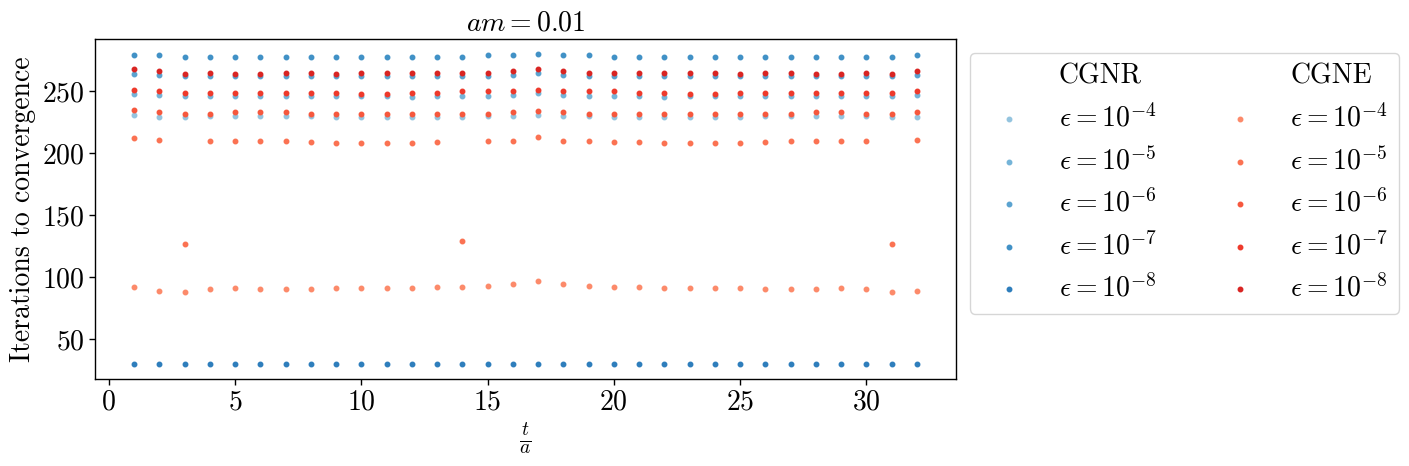

In [33]:
# convergence[mstr]['cgnr']['1e-5'][t]
# conv_cols = {
#     'cgnr' : colormaps['Blues'](np.linspace(0.5, 1, len(tol_lbls))),
#     'cgne' : colormaps['Oranges'](np.linspace(0.5, 1, len(tol_lbls))),
# }
conv_cols = {
    'cgnr' : colormaps['Blues'](np.linspace(0.4, 0.7, len(tol_lbls))),
    'cgne' : colormaps['Reds'](np.linspace(0.4, 0.7, len(tol_lbls))),
}
for mstr in mstr_lst:
    if mstr != '0p01':
        continue
    fig, axes = pt.add_subplots()
    ax = axes[0]
    for cg_type in convergence[mstr]:
        # for lbl, latex_lbl in zip(tol_lbls, tol_latex_lbls):
        for ii in range(len(tol_lbls)):
            plot_data = convergence[mstr][cg_type][tol_lbls[ii]]
            pt.scatter_1d(np.arange(1, 1 + len(plot_data)), plot_data, ax = ax, col = conv_cols[cg_type][ii], 
                          ax_label = [r'$\frac{t}{a}$', r'Iterations to convergence'], \
                          fn_label = '$\\epsilon = ' + tol_latex_lbls[ii] + '$', title = f'$am = {fmt.str_to_float(mstr)}$')
    h, l = ax.get_legend_handles_labels()
    handles = [plt.plot([],marker="", ls="")[0]] + h[:len(h) // 2] + [plt.plot([],marker="", ls="")[0]] + h[len(h)//2:]
    big_labels = ['CGNR'] + l[:len(l) // 2] + ['CGNE'] + l[len(l)//2:]
    plt.legend(handles, big_labels, ncol = 2, fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))

For a given tolerance $\epsilon_T$, the difference between the number of CGNE iterations and CGNR iterations is the speedup that CGNE would yield. Below, this difference is plotted for each mass $m$ and for the set of tolerances given above. We would hope that as the Dirac matrix becomes more ill-conditioned (smaller mass $m$), we would see the speedup increase at large times, since the large-$t$ components of the propagator should be more robust to lower modes when solving the system with CGNE. 

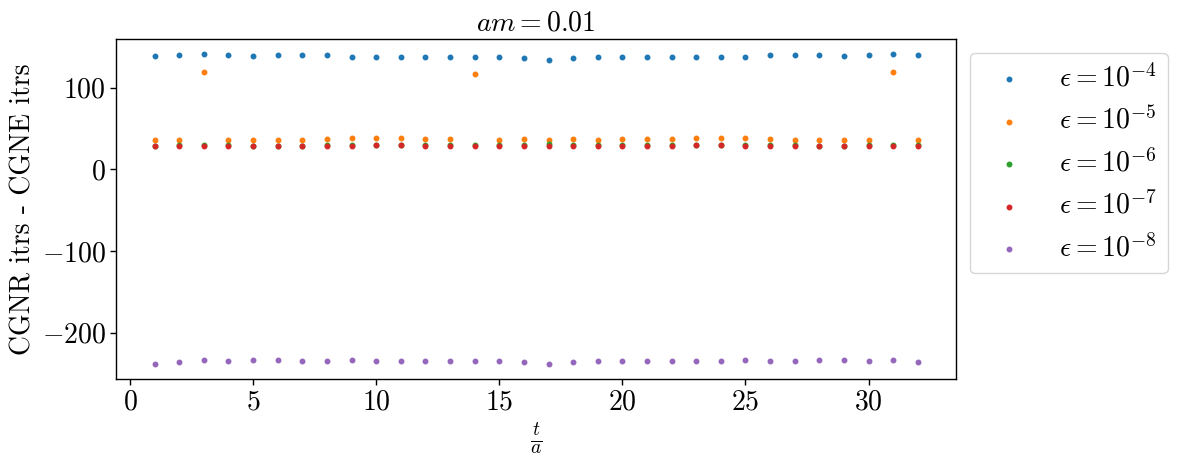

In [34]:
for mstr in mstr_lst:
    if mstr != '0p01':
        continue
    fig, axes = pt.add_subplots()
    ax = axes[0]
    for ii in range(len(tol_lbls)):
        plot_data = convergence[mstr]['cgnr'][tol_lbls[ii]] - convergence[mstr]['cgne'][tol_lbls[ii]]
        pt.scatter_1d(np.arange(1, 1 + len(plot_data)), plot_data, ax = ax, col = pt.pal[ii], 
                        ax_label = [r'$\frac{t}{a}$', r'CGNR itrs - CGNE itrs'], \
                        fn_label = '$\\epsilon = ' + tol_latex_lbls[ii] + '$', title = f'$am = {fmt.str_to_float(mstr)}$')
    plt.legend(fontsize = fmt.default_style['fontsize'], bbox_to_anchor = (1, 1))